<a href="https://colab.research.google.com/github/maram-834/workshop-repo/blob/main/Renewable_Energy_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team 1:
*   Maram Shatila
*   Reem Saab
*   Ruba Zeineddine
*   Ruba El Khalili
*   Ali Fahs

# Renewable Energy Forecasting using Multiple Linear Regression

The major problem towards utilizing non-conventional energy is the fluctuation of energy reception from these sources which makes the integration of these sources difficult into the grid. Maining an equilibrium between energy supply and demand can be erratic and this situation calls for forecasting the amount of electricity generated from Non Conventional Sources. Our team’s project, Renewable Energy Forecasting using Multiple Linear Regression, addresses one of the key challenges in integrating renewable energy into the grid — its fluctuating and unpredictable nature. By using machine learning to forecast solar energy generation based on weather and environmental data, our model helps predict the amount of energy that will be available in the next hour or day. This allows for better grid management, battery storage planning, and reduced reliance on diesel backups. Through this, we aim to contribute to energy resilience and sustainability, aligning with the hackathon’s goal.

LAT, LON: The geographic location, which is essential for solar prediction. Solar radiation differs based on latitude and longitude (e.g., regions near the equator get more sunlight).

YEAR, MO, DY: These time-related features are important to account for seasonality and weather patterns in solar energy generation.

QV2M (Humidity): Humidity impacts the clarity of the air and the amount of solar radiation that reaches the Earth's surface. High humidity often correlates with more cloud cover, reducing solar output.

KT: The clearness index is directly tied to how much of the solar energy that could reach the Earth actually does reach it. A lower KT value suggests more cloud cover or atmospheric interference.

DTI: Thermal flux

SII: solar irradiance, which will directly influence the amount of solar power that can be generated.

In [126]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [127]:
# Set variables for matplotlib for asthetics and size of graphs
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16,9]

# 2. Importing the Data and Assumptions:

The data exists in a CSV file and has data of Solar Insolation and various factors from NASA (add sources here).

Data was acquired for the Location: Latitude  28.6759   Longitude 77.1132 which corresponds to our college.

We will be predicting Solar Insolation Incident on a Horizontal Surface (kW-hr/m^2/day) using the parameters Downward Thermal Infrared (Longwave) Radiative Flux (kW-hr/m^2/day), Specific Humidity at 2 Meters (kg kg-1) and Insolation Clearness Index (dimensionless). Data is arranged in chronological order.

We'll be using the read_csv() of Pandas to fetch our data into a multidimensional data frame df of numpy.

In [128]:
# Loading Data
df = pd.read_csv('Insolation-Inputs.csv')

# Print first five rows of data frame to visualize the data.
print(df.head())

         date  energy_wh_day    GHI      temp     pressure   humidity  \
0  2017-01-02          10307  403.3  0.850000  1012.833333  92.333333   
1  2017-01-03           2256  234.7  1.420833  1008.458333  96.083333   
2  2017-01-04           3948  287.9  1.166667   996.666667  83.875000   
3  2017-01-05              0    0.0       NaN          NaN        NaN   
4  2017-01-06              0    0.0       NaN          NaN        NaN   

   wind_speed  rain_1h  snow_1h  clouds_all  ...  month  doy   doy_sin  \
0    4.750000     3.08     5.96   57.166667  ...      1    2  0.034398   
1    6.708333    35.20     5.36   95.250000  ...      1    3  0.051584   
2    8.375000    14.48    12.20   71.541667  ...      1    4  0.068755   
3         NaN     0.00     0.00         NaN  ...      1    5  0.085906   
4         NaN     0.00     0.00         NaN  ...      1    6  0.103031   

    doy_cos  energy_wh_day_lag1  energy_wh_day_lag2  energy_wh_day_lag7  \
0  0.999408              2039.0          

Display the list of Columns in the file as there may be too many columns and we may not need all of them.

In [129]:
# Show the list of all columns in the actual dataset
print(df.columns)

Index(['date', 'energy_wh_day', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'LAT', 'LON', 'YEAR',
       'MO', 'DY', 'QV2M', 'KT', 'DTI', 'SII', 'year', 'month', 'doy',
       'doy_sin', 'doy_cos', 'energy_wh_day_lag1', 'energy_wh_day_lag2',
       'energy_wh_day_lag7', 'energy_wh_day_rollmean3',
       'energy_wh_day_rollmean7', 'energy_wh_day_rollmean14'],
      dtype='object')


In [130]:
# See the list of data types for each column so that we can refine our data based on it
print(df.dtypes)

date                         object
energy_wh_day                 int64
GHI                         float64
temp                        float64
pressure                    float64
humidity                    float64
wind_speed                  float64
rain_1h                     float64
snow_1h                     float64
clouds_all                  float64
LAT                         float64
LON                         float64
YEAR                        float64
MO                          float64
DY                          float64
QV2M                        float64
KT                          float64
DTI                         float64
SII                         float64
year                          int64
month                         int64
doy                           int64
doy_sin                     float64
doy_cos                     float64
energy_wh_day_lag1          float64
energy_wh_day_lag2          float64
energy_wh_day_lag7          float64
energy_wh_day_rollmean3     

# 3. Clean up the columns

Our Model predicts the average insolation per day in the future based on the factors affecting insolation like
- Downward Thermal Infrared Radiative Flux
- Specific Humidity
- Isolation Clearness Index

So, out of the complete data, we need to keep data from only these columns and other columns containing the location can be dropped. The remaining fields are either 1) Date Fields, 2) Weather and Atmospheric data that represents our factors, 3) Solar Insolation data as only these features are useful for our prediction. The rest will be removed (dropped)

In [131]:
#drop unneeded features
df = df.drop(['LAT', 'LON'], axis=1)

print(df.columns)

Index(['date', 'energy_wh_day', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'YEAR', 'MO', 'DY',
       'QV2M', 'KT', 'DTI', 'SII', 'year', 'month', 'doy', 'doy_sin',
       'doy_cos', 'energy_wh_day_lag1', 'energy_wh_day_lag2',
       'energy_wh_day_lag7', 'energy_wh_day_rollmean3',
       'energy_wh_day_rollmean7', 'energy_wh_day_rollmean14'],
      dtype='object')


Let us now try to visualize the data based on Year

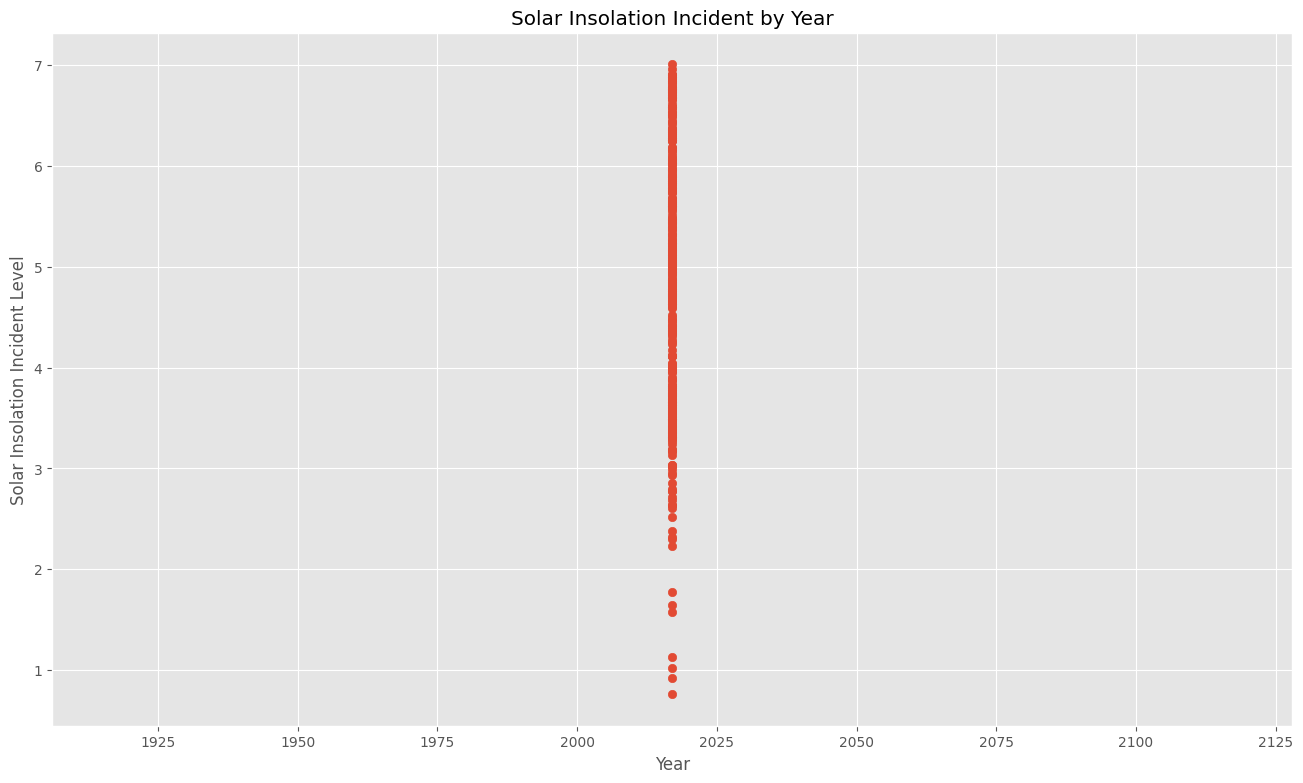

In [132]:
x = df['YEAR']
y = df['SII']
plt.scatter(x,y)
plt.xlabel('Year')
plt.ylabel('Solar Insolation Incident Level')
plt.title('Solar Insolation Incident by Year')
plt.show()

Sorting by year just lists items by year. We need to create items by date.

### Organizing by date

We can use year, month and day columns to create the date.

In [133]:
df['Date'] = pd.to_datetime(dict(year=df.YEAR, month=df.MO, day=df.DY))
print(df.head())

         date  energy_wh_day    GHI      temp     pressure   humidity  \
0  2017-01-02          10307  403.3  0.850000  1012.833333  92.333333   
1  2017-01-03           2256  234.7  1.420833  1008.458333  96.083333   
2  2017-01-04           3948  287.9  1.166667   996.666667  83.875000   
3  2017-01-05              0    0.0       NaN          NaN        NaN   
4  2017-01-06              0    0.0       NaN          NaN        NaN   

   wind_speed  rain_1h  snow_1h  clouds_all  ...  doy   doy_sin   doy_cos  \
0    4.750000     3.08     5.96   57.166667  ...    2  0.034398  0.999408   
1    6.708333    35.20     5.36   95.250000  ...    3  0.051584  0.998669   
2    8.375000    14.48    12.20   71.541667  ...    4  0.068755  0.997634   
3         NaN     0.00     0.00         NaN  ...    5  0.085906  0.996303   
4         NaN     0.00     0.00         NaN  ...    6  0.103031  0.994678   

   energy_wh_day_lag1  energy_wh_day_lag2  energy_wh_day_lag7  \
0              2039.0            

Now, there is no need for YEAR, MO and DY columns and hence we can drop them as well.

In [134]:
#drop unneeded features
df = df.drop(['YEAR', 'MO', 'DY', 'date' ], axis=1)

print(df.columns)

Index(['energy_wh_day', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed',
       'rain_1h', 'snow_1h', 'clouds_all', 'QV2M', 'KT', 'DTI', 'SII', 'year',
       'month', 'doy', 'doy_sin', 'doy_cos', 'energy_wh_day_lag1',
       'energy_wh_day_lag2', 'energy_wh_day_lag7', 'energy_wh_day_rollmean3',
       'energy_wh_day_rollmean7', 'energy_wh_day_rollmean14', 'Date'],
      dtype='object')


We need to separate our dataframe df into Inputs (X) and Outputs (y). We can do that easily with drop and slicing.

In [135]:
# Separate independent variable data (X) from dependent variable data (Y)
y = df['SII']
X = df.drop(['SII','Date'], axis=1)

print(f'Inputs: {X}')
print(f'Outputs: {y}')
print(df)

Inputs:       energy_wh_day     GHI       temp     pressure   humidity  wind_speed  \
0             10307   403.3   0.850000  1012.833333  92.333333    4.750000   
1              2256   234.7   1.420833  1008.458333  96.083333    6.708333   
2              3948   287.9   1.166667   996.666667  83.875000    8.375000   
3                 0     0.0        NaN          NaN        NaN         NaN   
4                 0     0.0        NaN          NaN        NaN         NaN   
...             ...     ...        ...          ...        ...         ...   
2063          96183  4667.5  21.191667  1011.250000  79.833333    2.762500   
2064          19886  1459.7  18.829167  1014.333333  89.125000    3.662500   
2065          41137  2160.9  16.525000  1017.833333  87.416667    3.820833   
2066          80660  4283.0  16.191667  1022.125000  81.625000    2.862500   
2067          84259  5258.4  15.161111  1023.611111  74.222222    2.866667   

      rain_1h  snow_1h  clouds_all      QV2M  ...  mont

# Visualization of Data

We can visualize the data dependency on one another using a Correlation Matrix of Seaborn.

<Axes: >

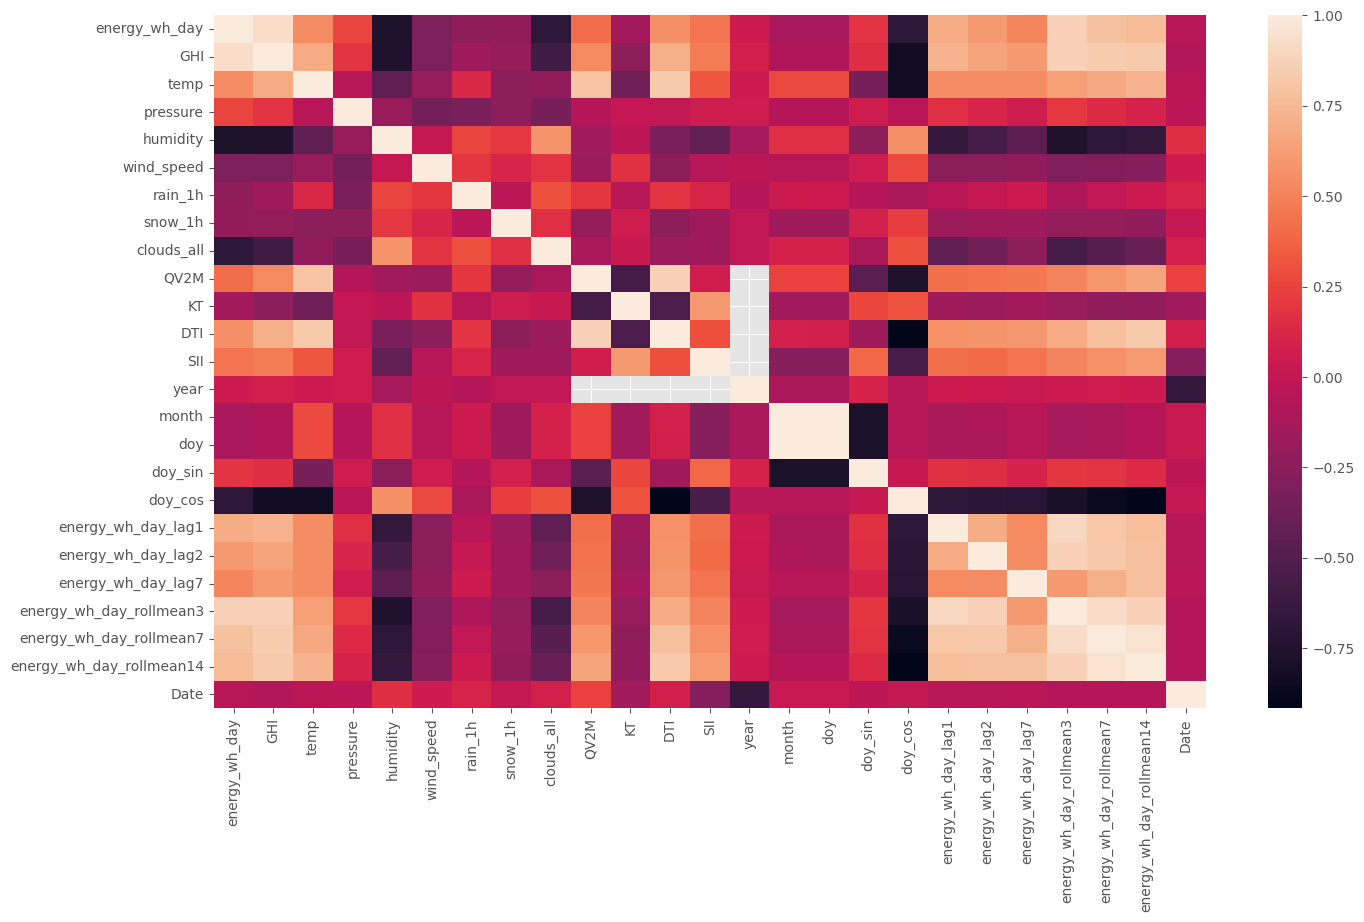

In [136]:
# Data visualization using a Correlation Matrix
sns.heatmap(df.corr())

From above heatmap, we can determine that SII is dependent the most on KT (Insolation Clearness Index), then on DTI (Downward Thermal Infrared Radiative Flux) and least on QV2M (Specific Humidity).

We can also plot the solar insolation over length of time.

In [137]:
def time_series(start, end):
    time_series_df = df[['Date', 'SII']][(df['Date'] >= start) & (df['Date'] <= end)]
    x1 = time_series_df.Date
    y1 = time_series_df.SII
    plt.plot(x1,y1)
    plt.xlabel('Time')
    plt.ylabel('Solar Insolation Value')
    plt.title('Solar Insolation Incident Time Series')
    return plt.show();

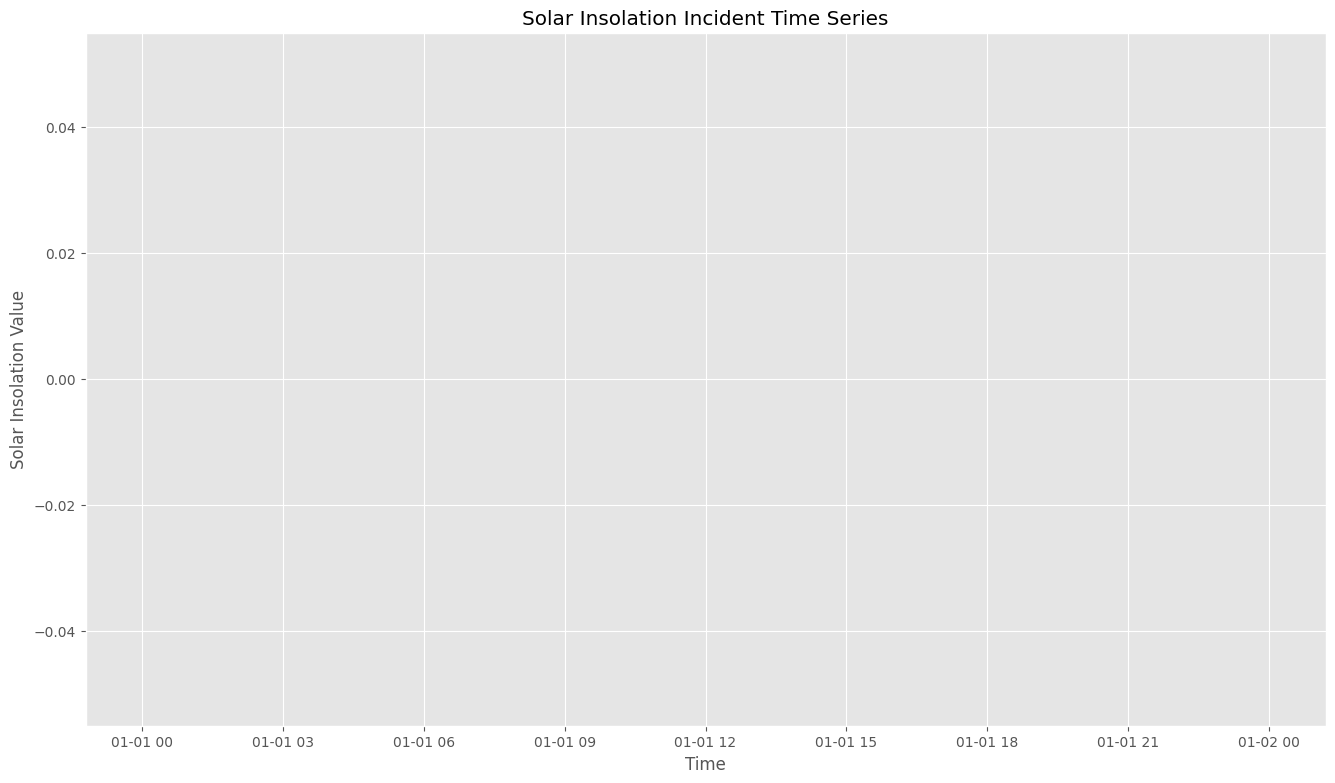

In [138]:
time_series('2010','2017')

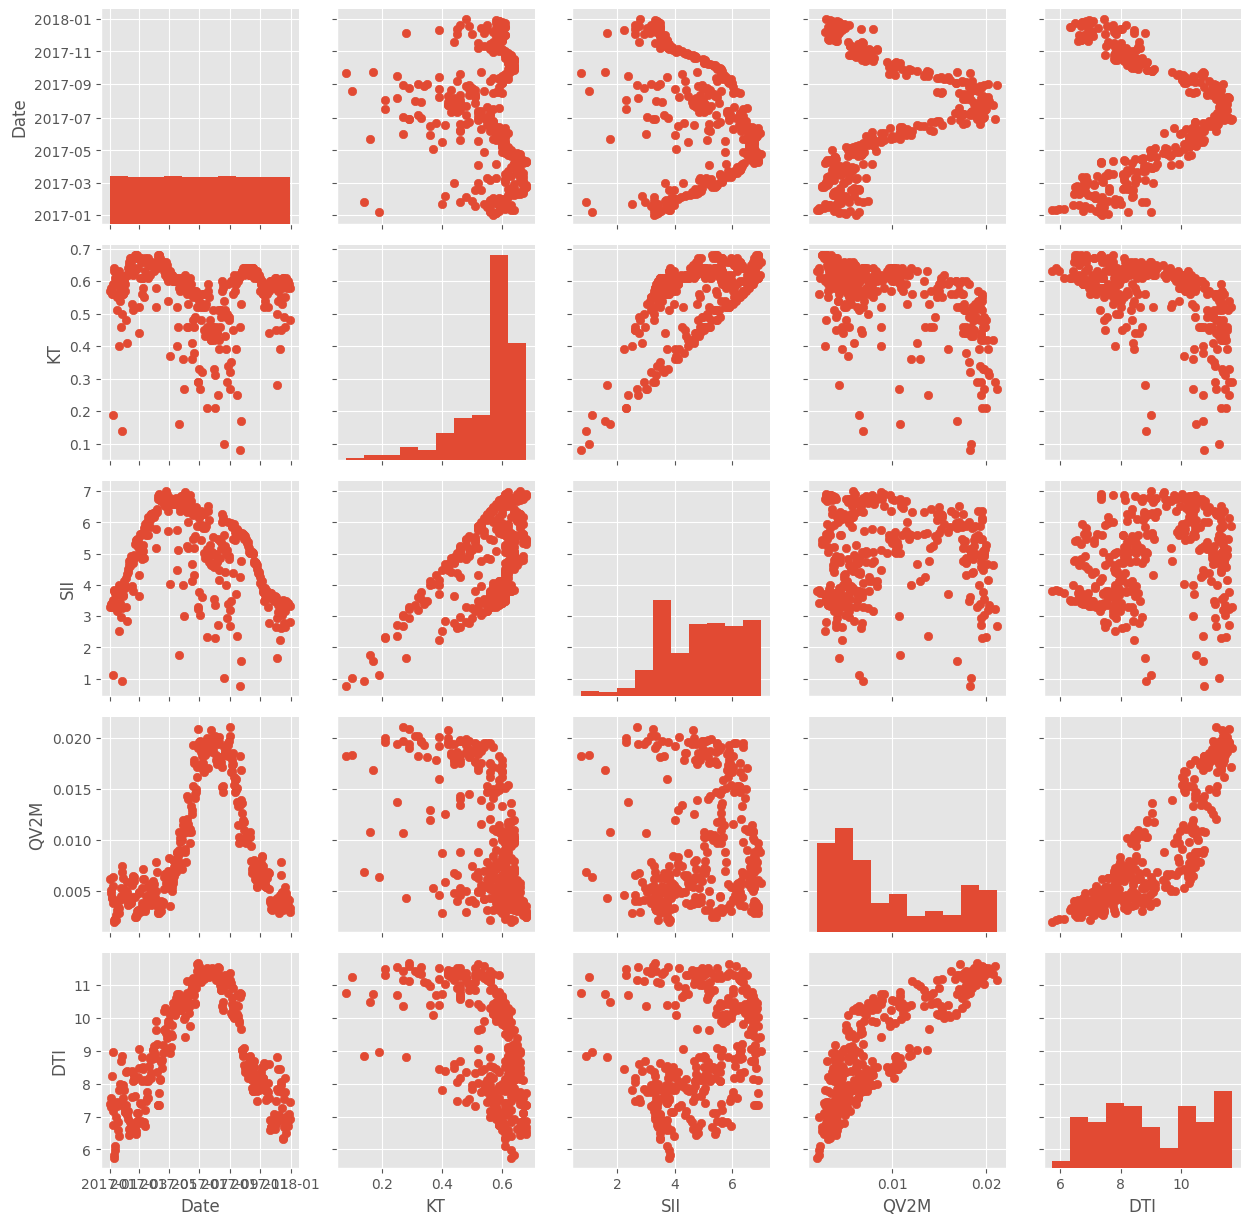

In [139]:
g = sns.PairGrid(df, vars=["Date", "KT", "SII", "QV2M", "DTI"], dropna=True)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);

# Preprocessing Data using SKLEARN preprocessor.

We can using the preprocessor to separate the labels that computer will not understand and place values in its place that computers will understand.


# Split into Training and Test Data

We will split the data into training and test data. Cross validation is always desired when training machine learning models to be able to trust the generality of the model created. We will split our data into training and test data using Scikit learn's built in tools. X and y (inputs and outputs) have already been created previously.

sklearn's train_test_split allows us to randomly split the data. Here we are keeping 25% of the data for testing and the rest of the data for training.

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [141]:
# Check number of rows in training data
X_train.shape, y_train.shape

((1551, 23), (1551,))

In [142]:
# Check number of rows in testing data
X_test.shape, y_test.shape

((517, 23), (517,))

# Implement ML Algorithms

We are going to implement various algorithms here:
- Linear Regression
- Neural Network Regression
- Random Forest Regression
- Lasso
- Elastic Net
- Extra Trees Regression

### Linear Regression

Linear regression is a linear approach to modeling the relationship between a scalar response (or dependent variable) and one or more explanatory variables (or independent variables).

In [143]:
from sklearn.linear_model import LinearRegression

# Handle missing values by filling them with the column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

# Create and fit the linear regression model
regr = LinearRegression()
regr.fit(X_train, y_train)

# Make predictions
lin_pred = regr.predict(X_test)

# Evaluate the model
print("Linear regression score:", regr.score(X_test, y_test))



Linear regression score: 0.9172414798919419


0.9172414798919419
Coefficients: 
 [-9.60316668e-06 -1.61072142e-05 -1.13761260e-04  7.25809744e-04
  7.42276613e-04 -4.63472013e-04  1.11431408e-04 -1.09219855e-03
  1.69666236e-04 -7.26184150e+01  1.21280198e+01  8.79527180e-01
 -2.43766892e-03  2.09645113e-02 -7.44617942e-04  5.21094357e-02
 -7.24560614e-02 -1.04676685e-05 -1.02609346e-05 -2.01386002e-07
  3.17586767e-05 -7.94560355e-07  2.72327771e-08]
Root mean squared error: 0.17
Mean absolute error: 0.09
R-squared: 0.92


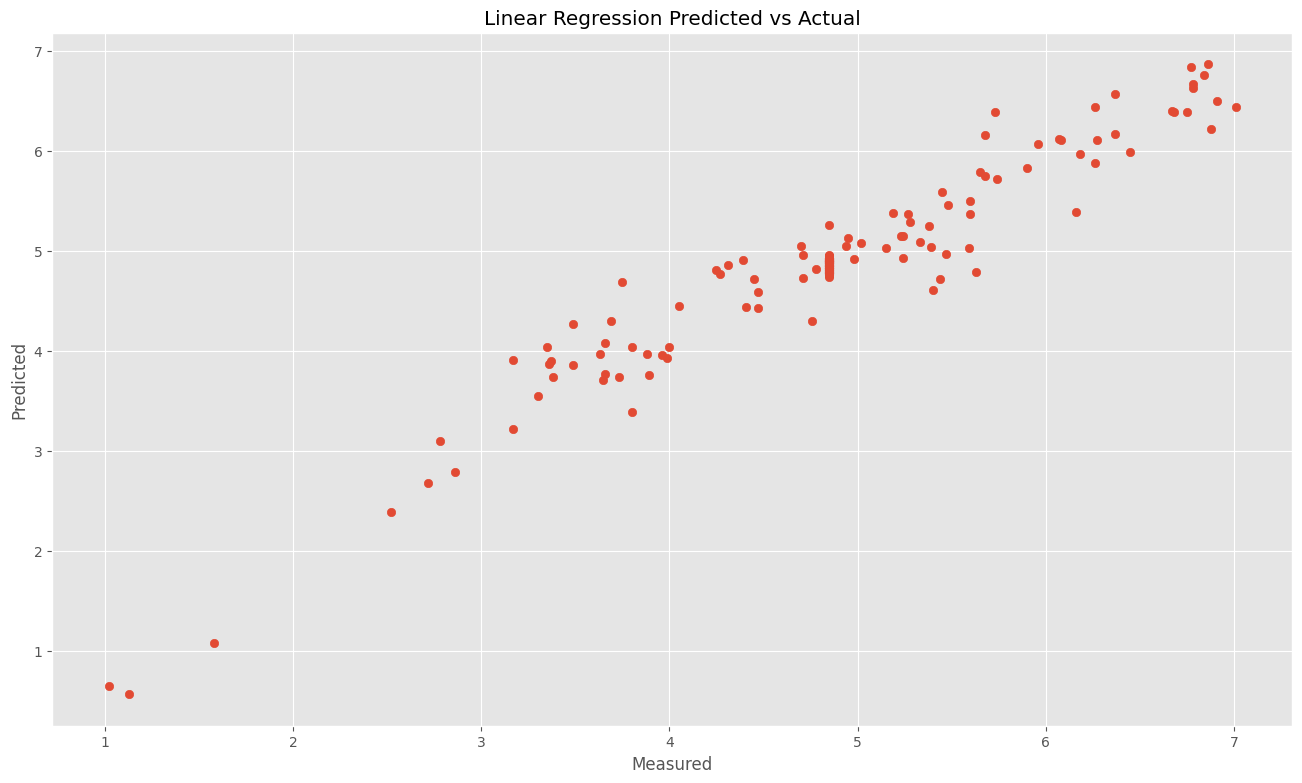

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
lin_pred = regr.predict(X_test)

linear_regression_score = regr.score(X_test, y_test)
print(linear_regression_score)

from math import sqrt
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lin_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, lin_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, lin_pred))

plt.scatter(y_test, lin_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Linear Regression Predicted vs Actual')
plt.show()

### Neural Network Regression

If you need a more complex model, applying a neural network to the problem can provide much more prediction power compared to a traditional regression.

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


-200461.16323812283
Root mean squared error: 257.04
Mean absolute error: 187.36
R-squared: -200461.16


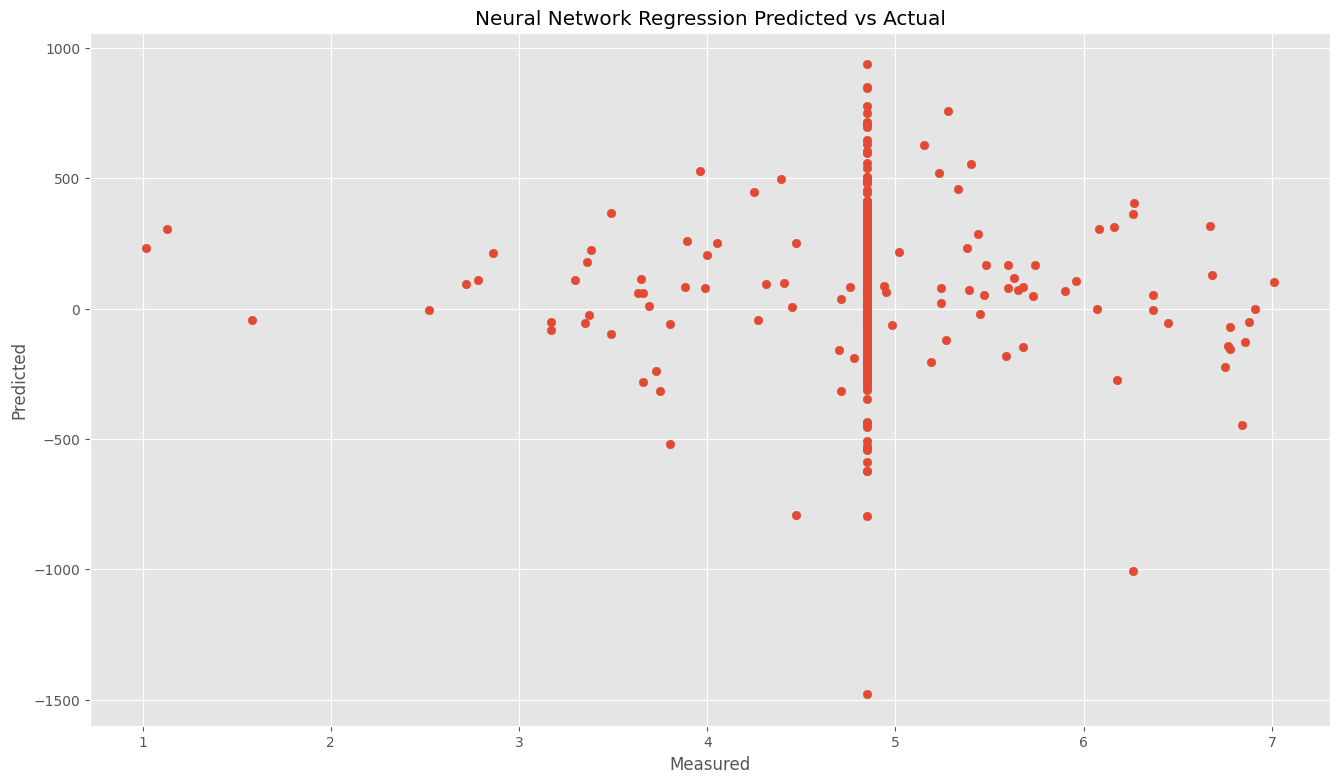

In [145]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create MLPRegressor object
mlp = MLPRegressor()

# Train the model using the training sets
mlp.fit(X_train, y_train)

# Score the model
neural_network_regression_score = mlp.score(X_test, y_test)
print(neural_network_regression_score)

# Make predictions using the testing set
nnr_pred = mlp.predict(X_test)

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, nnr_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, nnr_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, nnr_pred))

plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

### Random Forest Regression

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

0.9401010559414645
Root mean squared error: 0.14
Mean absolute error: 0.10
R-squared: 0.94
Index(['energy_wh_day', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed',
       'rain_1h', 'snow_1h', 'clouds_all', 'QV2M', 'KT', 'DTI', 'year',
       'month', 'doy', 'doy_sin', 'doy_cos', 'energy_wh_day_lag1',
       'energy_wh_day_lag2', 'energy_wh_day_lag7', 'energy_wh_day_rollmean3',
       'energy_wh_day_rollmean7', 'energy_wh_day_rollmean14'],
      dtype='object')


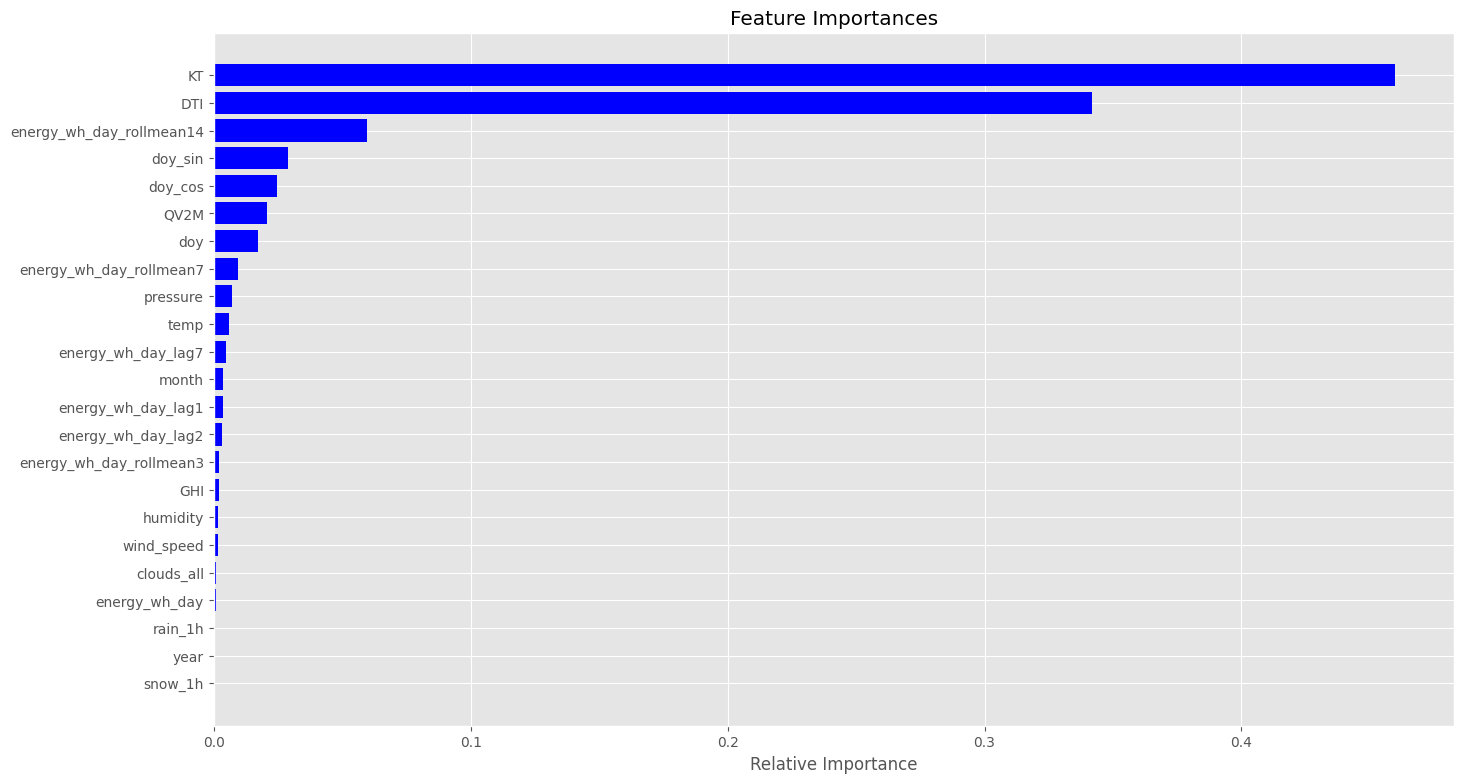

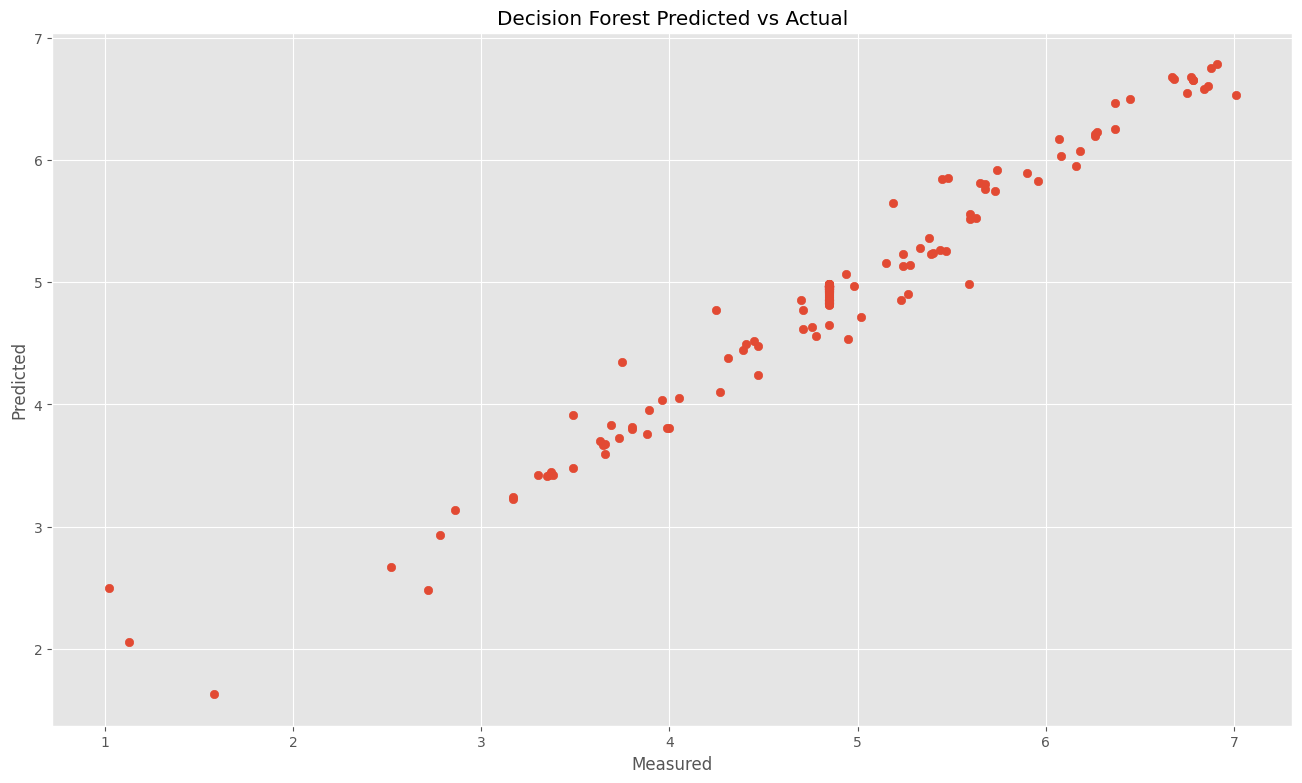

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Create Random Forrest Regressor object
regr_rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Train the model using the training sets
regr_rf.fit(X_train, y_train)

# Score the model
decision_forest_score = regr_rf.score(X_test, y_test)
print(decision_forest_score)

# Make predictions using the testing set
regr_rf_pred = regr_rf.predict(X_test)

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
# The absolute squared error
print("Mean absolute error: %.2f"
      % mean_absolute_error(y_test, regr_rf_pred))
# Explained variance score: 1 is perfect prediction
print('R-squared: %.2f' % r2_score(y_test, regr_rf_pred))

print(X.columns)

features = X.columns
importances = regr_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

plt.scatter(y_test, regr_rf_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Decision Forest Predicted vs Actual')
plt.show()

### Lasso

Least Absolute Shrinkage and Selection Operator (LASSO) regression shrinks the regression coefficients to solve the multicollinearity problem. However, Lasso regression shrinks the absolute values, not the least squares, meaning some of the coefficients can become zero. This leads to “feature selection”—if a group of dependent variables are highly correlated, it picks one and shrinks the others to zero.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+02, tolerance: 4.834e-02
  model = cd_fast.enet_coordinate_descent(


0.04420926161740779
Root mean squared error: 0.56


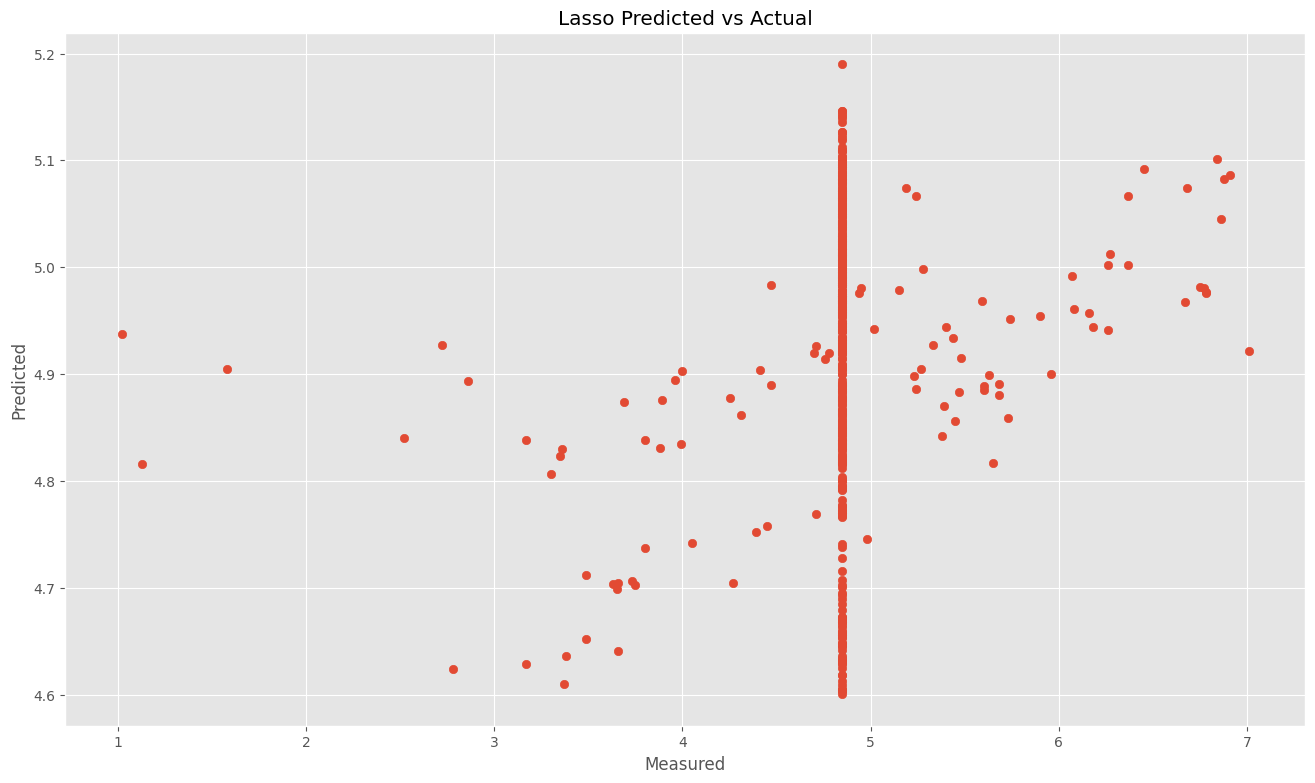

In [147]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(X_train, y_train)

# Score the model
lasso_score = lasso.score(X_test, y_test)
print(lasso_score)

# Make predictions using the testing set
lasso_pred = lasso.predict(X_test)

print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, lasso_pred)))

plt.scatter(y_test, lasso_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Lasso Predicted vs Actual')
plt.show()

### ElasticNet

ElasticNet combines Ridge and Lasso regression, and is trained successively with L1 and L2 regularization, thus trading-off between the two techniques. The advantage is that ElasticNet gains the stability of Ridge regression while allowing feature selection like Lasso. Whereas Lasso will pick only one variable of a group of correlated variables, ElasticNet encourages a group effect and may pick more than one correlated variables.

In [148]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet()

elasticnet.fit(X_train, y_train)

elasticnet_score = elasticnet.score(X_test, y_test)
print(elasticnet_score)

elasticnet_pred = elasticnet.predict(X_test)

# The mean squared error
print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, elasticnet_pred)))

0.04413469019976457
Root mean squared error: 0.56


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e+02, tolerance: 4.834e-02
  model = cd_fast.enet_coordinate_descent(


### Extra Trees Regression

This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

0.9083257093535809
Root mean squared error: 0.17


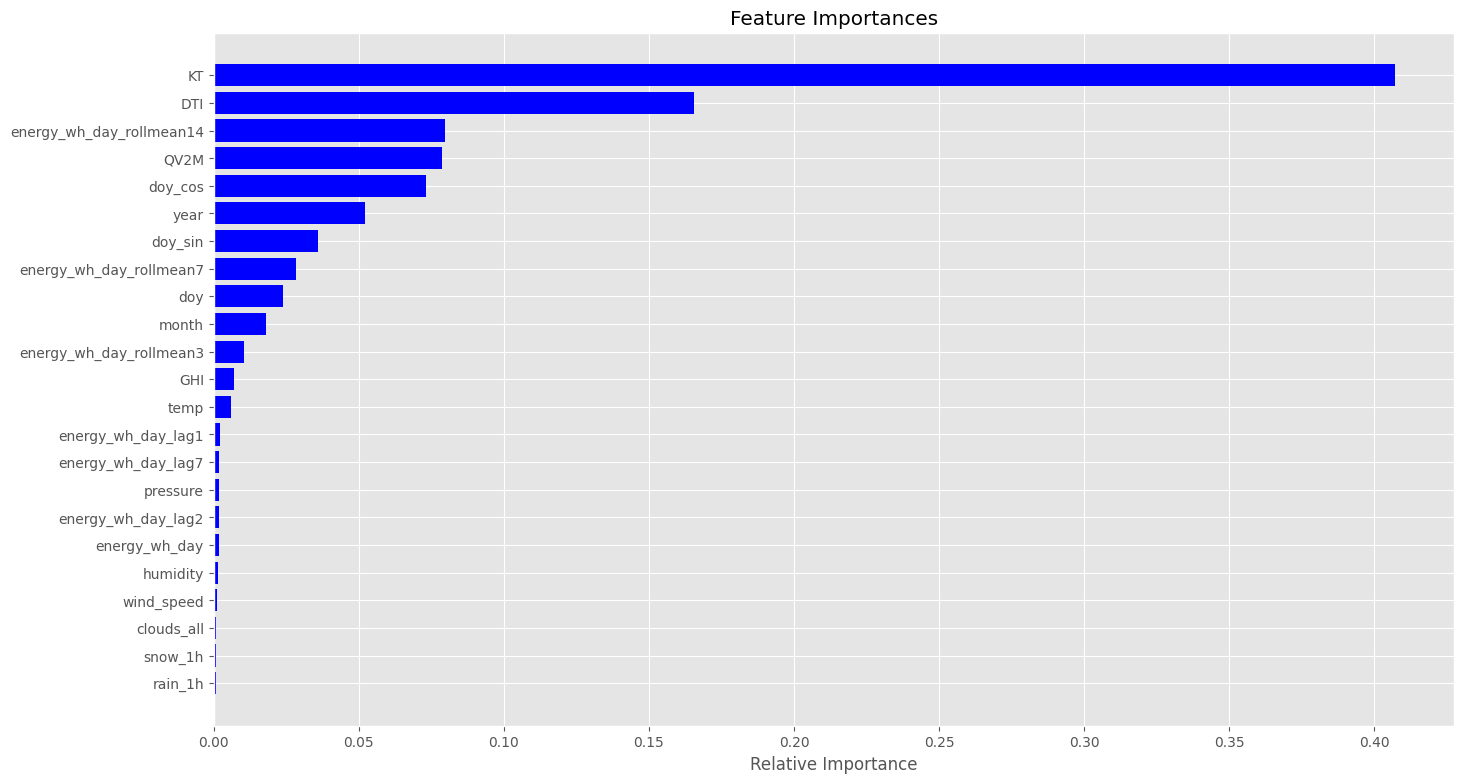

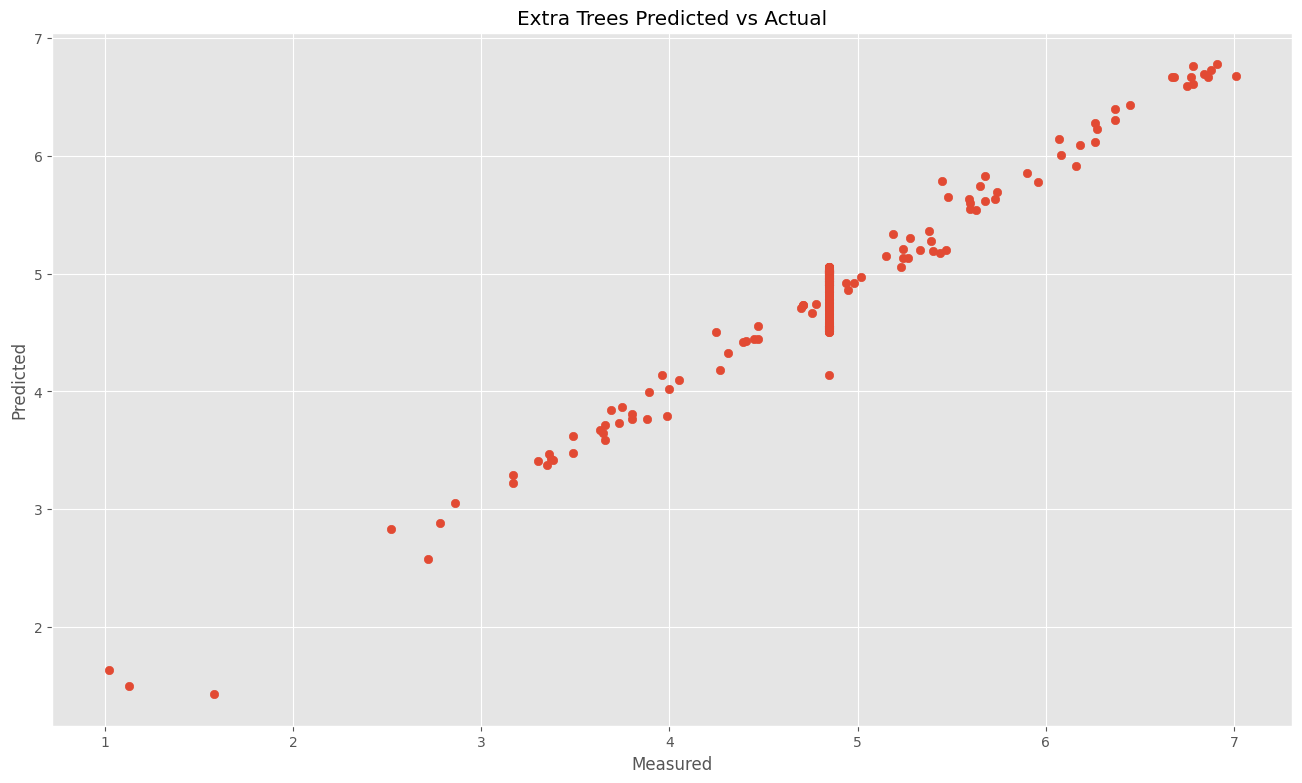

In [149]:
from sklearn.ensemble import ExtraTreesRegressor

extra_tree = ExtraTreesRegressor(n_estimators=200, random_state=0)

extra_tree.fit(X_train, y_train)

extratree_score = extra_tree.score(X_test, y_test)
print(extratree_score)

extratree_pred = extra_tree.predict(X_test)

print("Root mean squared error: %.2f"
      % sqrt(mean_squared_error(y_test, extratree_pred)))

features = X.columns
importances = extra_tree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

plt.scatter(y_test, extratree_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Extra Trees Predicted vs Actual')
plt.show()

# Evaluate Models

In [150]:
print("Scores:")
print("Linear regression score: ", linear_regression_score)
print("Neural network regression score: ", neural_network_regression_score)
print("Lasso regression score: ", lasso_score)
print("ElasticNet regression score: ", elasticnet_score)
print("Random Forest score: ", decision_forest_score)
print("Extra Trees score: ", extratree_score)
print("\n")
print("RMSE:")
print("Linear regression RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, lin_pred)))
print("Neural network RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, nnr_pred)))
print("Lasso RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, lasso_pred)))
print("ElasticNet RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, elasticnet_pred)))
print("Random Forest RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, regr_rf_pred)))
print("Extra Trees RMSE: %.2f"
      % sqrt(mean_squared_error(y_test, extratree_pred)))

Scores:
Linear regression score:  0.9172414798919419
Neural network regression score:  -200461.16323812283
Lasso regression score:  0.04420926161740779
ElasticNet regression score:  0.04413469019976457
Random Forest score:  0.9401010559414645
Extra Trees score:  0.9083257093535809


RMSE:
Linear regression RMSE: 0.17
Neural network RMSE: 257.04
Lasso RMSE: 0.56
ElasticNet RMSE: 0.56
Random Forest RMSE: 0.14
Extra Trees RMSE: 0.17


The Random Forest model achieved the best performance overall, with the highest R² (0.94) and the lowest RMSE (0.14), indicating strong predictive accuracy and stability. In contrast, the Neural Network performed poorly, suggesting overfitting or improper scaling, while the Linear Regression and tree-based models provided consistently reliable results for solar energy forecasting.

Mean Squared Error: 0.000106
Root Mean Squared Error: 0.010278
R² Score: 0.9996

Predicted Solar Output: 3.1691 kWh/m²/day


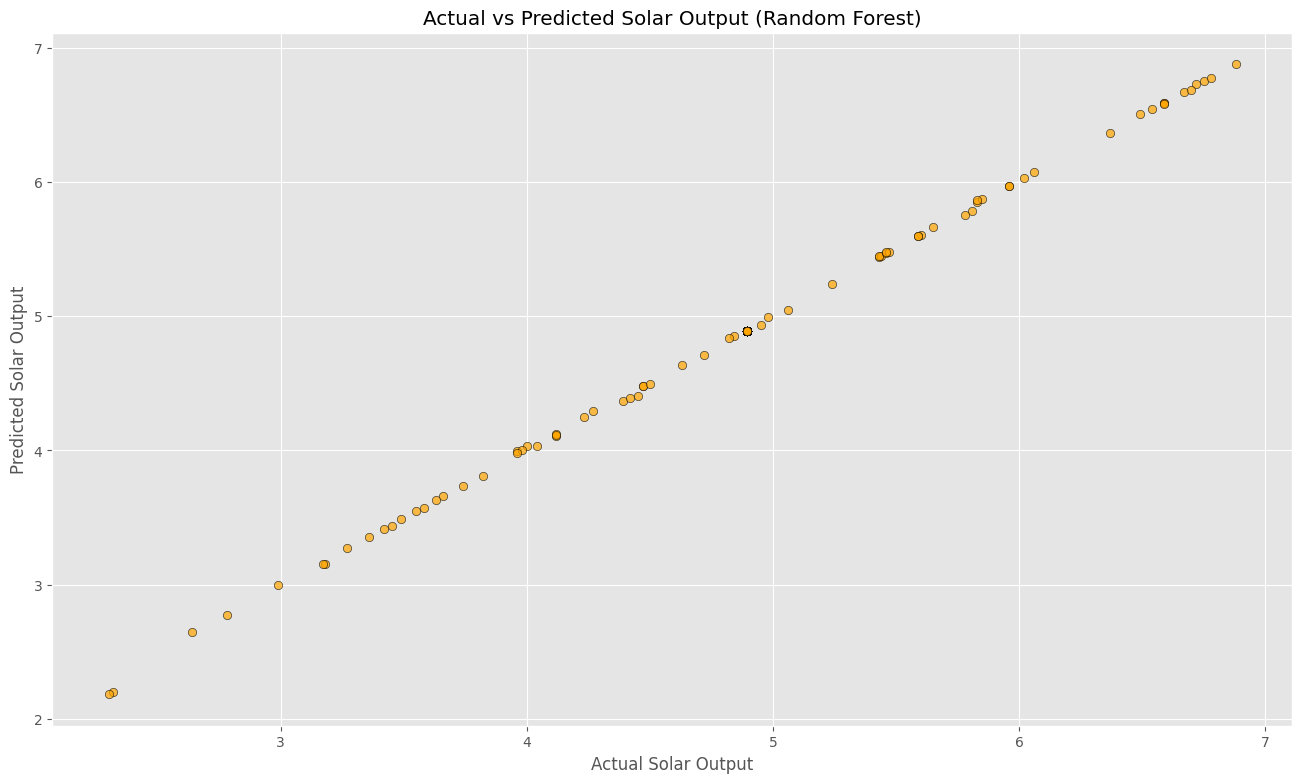

In [151]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('Insolation-Inputs.csv')

# Select relevant features for prediction
features = ['QV2M', 'KT', 'DTI', 'SII']  # You can add more if needed
X = data[features]
y = data['SII']  # Target variable (solar irradiance index)

# Handle missing values by replacing them with column means
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict the solar energy output on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.6f}")
print(f"Root Mean Squared Error: {mse**0.5:.6f}")
print(f"R² Score: {model.score(X_test, y_test):.4f}")

# Example: Predict solar energy output for new data
new_data = pd.DataFrame({
    'QV2M': [0.003],  # Example humidity value
    'KT': [0.6],      # Example solar radiation ratio
    'DTI': [6.5],     # Example thermal infrared flux
    'SII': [3.2]      # Example solar irradiance index
})

predicted_output = model.predict(new_data)
print(f"\nPredicted Solar Output: {predicted_output[0]:.4f} kWh/m²/day")

# Visualization — Actual vs Predicted Solar Output
plt.scatter(y_test, y_pred, alpha=0.7, color='orange', edgecolor='k')
plt.xlabel('Actual Solar Output')
plt.ylabel('Predicted Solar Output')
plt.title('Actual vs Predicted Solar Output (Random Forest)')
plt.show()


The plot above shows that the predicted values are very close to the actual values, with a near-perfect linear relationship. The Mean Squared Error (MSE) is very low (0.000106), which further confirms that the model is making very accurate predictions.